In [1]:
!pip install pandas numpy tensorflow scikit-learn


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pickle
import time

Load data

In [3]:
train_df = pd.read_csv("../../../data/train_data.csv")  
val_df = pd.read_csv("../../../data/val_data.csv")     
test_df = pd.read_csv("../../../data/test_data.csv") 

Ensure all text fields are strings and fill NaNs

In [4]:
train_df["text"] = train_df["text"].astype(str).fillna("")
val_df["text"] = val_df["text"].astype(str).fillna("")
test_df["text"] = test_df["text"].astype(str).fillna("")

Encode labels using LabelEncoder

In [5]:
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["Analysis"])
val_df["label"] = label_encoder.transform(val_df["Analysis"])
test_df["label"] = label_encoder.transform(test_df["Analysis"])
num_classes = len(label_encoder.classes_)

Tokenise text

In [6]:
max_vocab = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"])

def prep_text(data): # Prepare text for LSTM
    sequences = tokenizer.texts_to_sequences(data["text"]) # Convert text to sequences
    return pad_sequences(sequences, maxlen=max_len) # Pad sequences to the same length

X_train = prep_text(train_df)
X_val = prep_text(val_df)
X_test = prep_text(test_df)

y_train = to_categorical(train_df["label"], num_classes)
y_val = to_categorical(val_df["label"], num_classes)
y_test = to_categorical(test_df["label"], num_classes)


# Save the tokenizer
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save the tokenizer


Load GloVe emddings to give LSTM model pre-trained knowledge of how words relate to each other before training starts

Download glove.6B from https://nlp.stanford.edu/projects/glove/ : https://nlp.stanford.edu/data/glove.6B.zip
* Unzip the folder and drag the glove.6B.100d.txt to the `pre-trained_model` directory 

In [7]:
embedding_dim = 100 # Dimension of the embedding vectors
embedding_index = {} 

with open("../../pretrained_model/glove.6B.100d.txt", encoding="utf8") as f: # Load the GloVe embeddings
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coef

# Create embedding matrix 
word_index = tokenizer.word_index # Get the word index
embedding_matrix = np.zeros((max_vocab, embedding_dim)) # Create a matrix of zeros

for word, i in word_index.items(): # Iterate through the word index
    if i < max_vocab: # Check if the word index is less than the maximum vocabulary
        vec = embedding_index.get(word) # Get the embedding vector for the word
        if vec is not None: # Check if the embedding vector is not None
            embedding_matrix[i] = vec # Assign the embedding vector to the matrix

Build the LSTM model

In [8]:
model = Sequential()
model.add(Embedding(max_vocab, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Train the model

In [9]:
# Initialize time for recording inference time
start = time.time()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

end = time.time()
training_time = end - start

Epoch 1/10


283/283 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - accuracy: 0.5855 - loss: 0.9140 - val_accuracy: 0.6438 - val_loss: 0.7899
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - accuracy: 0.6460 - loss: 0.7841 - val_accuracy: 0.6686 - val_loss: 0.7374
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - accuracy: 0.6731 - loss: 0.7230 - val_accuracy: 0.6825 - val_loss: 0.7075
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.6972 - loss: 0.6768 - val_accuracy: 0.7145 - val_loss: 0.6845
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.7342 - loss: 0.6169 - val_accuracy: 0.7341 - val_loss: 0.6257
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.7546 - loss: 0.5801 - val_accuracy: 0.7326 - val_loss: 0.6319
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 162ms/step - accuracy: 0.7800 - loss: 0.5293 - val_accuracy: 0.7589 - val_loss: 0.5910
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - accuracy: 0.7914 - loss: 0.4994 - val

In [10]:
# Save computation time to CSV
time_df = pd.DataFrame({"lstm_TrainingTime (s)": [training_time]})
time_df.to_csv("computation_time_lstm.csv", index=False)

print("Training time: ", training_time, "seconds")
print("Training time is saved")

Training time:  409.44276905059814 seconds
Training time is saved


In [11]:
model.save("lstm.keras")
print("Model saved")

Model saved


Plot accuracy over epochs

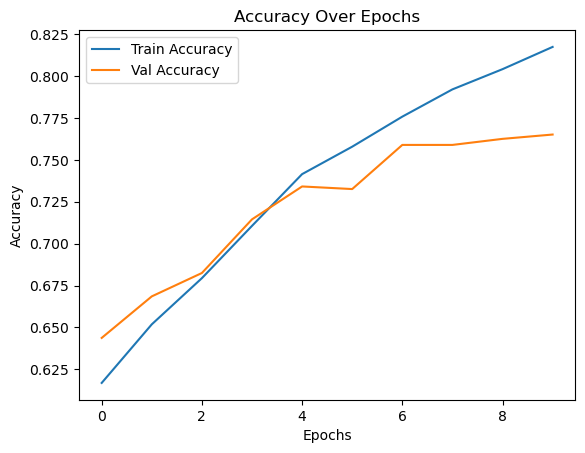

In [12]:
from matplotlib import pyplot as plt 

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_epochs_lstm.png")
plt.show()

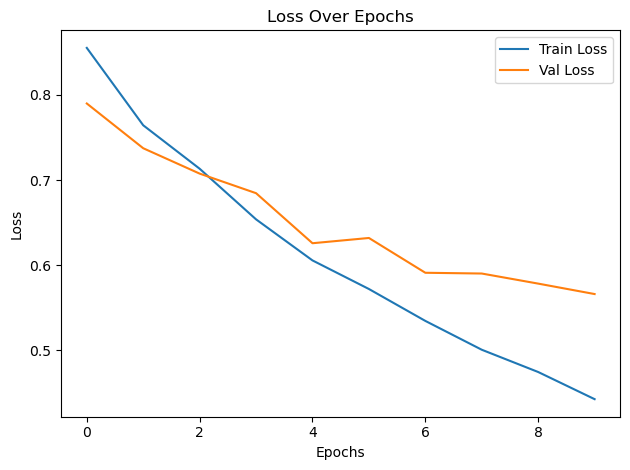

In [13]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("loss_epochs_lstm.png")
plt.show()

Download GloVe at https://nlp.stanford.edu/projects/glove/